In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from typing import Dict, List, Tuple
import glob


OUTPUT_ROOT_DIR = "your path here to Grokking_analysis/output"


def _eval_res(gold: str, pred: str) -> int:
    """Compare gold and pred; focus on contents inside <a>...</a> if present."""
    if gold is None or pred is None:
        return 0
    a = str(gold).strip()
    b = str(pred).strip()
    if "</a>" in a:
        a = a.split("</a>")[0]
    if "</a>" in b:
        b = b.split("</a>")[0]
    if "<a>" in a and "<a>" in b:
        try:
            a_inner = a.split("<a>")[1]
            b_inner = b.split("<a>")[1]
            return int(a_inner == b_inner)
        except Exception:
            return int(a == b)
    return int(a == b)

def _eval_items(all_items):
    """Given list of items, return mapping type -> list of 0/1 correctness."""
    acc = {}
    for item in all_items:
        t = item.get("type", "test_inferred")
        pred = item.get("model_output", item.get("model output", None))
        gold = item.get("target_text", item.get("target text", None))
        correct = _eval_res(gold, pred)
        acc.setdefault(t, []).append(correct)
    return acc

def parse_tokens(text):
    """analysis token"""
    return re.findall(r"<[^>]+>", text)

def get_target_token(tokens):
    """get target token"""
    if "</a>" in tokens:
        idx = tokens.index("</a>")
        if idx > 0:
            return tokens[idx-1]
    return None

def build_bridge_lookup_from_all_items(all_items_data):

    hr_to_bridge = {}
    
    for item in all_items_data:
        input_text = item.get('input_text', '')
        target_text = item.get('target_text', '')
        
        inp_tokens = parse_tokens(input_text)
        
        
        if len(inp_tokens) == 2:
            h, r = inp_tokens[0], inp_tokens[1]
            bridge = get_target_token(parse_tokens(target_text))
            if bridge:
                hr_to_bridge[(h, r)] = bridge
    
    return hr_to_bridge

def analyze_single_sample(sample, hr_to_bridge):

    input_text = sample['input_text']
    target_text = sample['target_text']
    
    inp_tokens = parse_tokens(input_text)
    if len(inp_tokens) != 3:
        return None
    
    h, r1, r2 = inp_tokens
    true_bridge = hr_to_bridge.get((h, r1))
    if not true_bridge:
        return None
    
    target_token = get_target_token(parse_tokens(target_text))
    if not target_token:
        return None
    
    trace = sample.get('logit_lens_trace', [])
    has_bridge_ever = False
    has_target_ever = False
    
    for stage_data in trace:
        predictions = stage_data['predictions']
        if true_bridge in predictions:
            has_bridge_ever = True
        if target_token in predictions:
            has_target_ever = True
    
    return {
        'has_bridge': has_bridge_ever,
        'has_target': has_target_ever
    }

def compute_bridge_target_rates(logit_lens_data, hr_to_bridge):
    
    total = 0
    bridge_found = 0
    target_found = 0
    
    for sample in logit_lens_data:
        analysis = analyze_single_sample(sample, hr_to_bridge)
        if analysis is None:
            continue
        
        total += 1
        if analysis['has_bridge']:
            bridge_found += 1
        if analysis['has_target']:
            target_found += 1
    
    if total == 0:
        return 0.0, 0.0
    
    return bridge_found / total, target_found / total

def collect_circuit_series(checkpoint_dir: str):
    """
    For one data folder:
      - steps
      - bridge_found_rate (from logit_lens_ood.json)
      - target_found_rate (from logit_lens_ood.json)
      - training_accuracy = mean(id_atomic, ood_atomic, train_inferred) per checkpoint
    """
    pattern = os.path.join(checkpoint_dir, "checkpoint-*")
    ckpts = [p for p in glob.glob(pattern) if os.path.isdir(p)]
    if not ckpts:
        raise FileNotFoundError(f"No checkpoints found under {checkpoint_dir}")

    ckpt_steps = []
    for p in ckpts:
        m = re.search(r"checkpoint-(\d+)", p)
        if not m:
            continue
        step = int(m.group(1))
        logit_lens_path = os.path.join(p, "logit_lens_ood.json")
        all_items_path = os.path.join(p, "all_items.json")
        if os.path.exists(logit_lens_path) and os.path.exists(all_items_path):
            ckpt_steps.append((step, p, logit_lens_path, all_items_path))

    ckpt_steps.sort(key=lambda x: x[0])
    if not ckpt_steps:
        raise RuntimeError(f"No valid checkpoints with both logit_lens_ood.json and all_items.json under {checkpoint_dir}")

    # build bridge lookup from first checkpoint's all_items
    with open(ckpt_steps[0][3], "r", encoding="utf-8") as f:
        first_all_items = json.load(f)
    hr_to_bridge = build_bridge_lookup_from_all_items(first_all_items)

    steps = []
    bridge_rates = []
    target_rates = []
    training_acc = []

    for step, _ckpt_path, logit_lens_path, all_items_path in tqdm(ckpt_steps, desc=f"Collecting {os.path.basename(checkpoint_dir)}"):
        # logit-lens rates
        try:
            with open(logit_lens_path, "r", encoding="utf-8") as f:
                logit_data = json.load(f)
            br, tr = compute_bridge_target_rates(logit_data, hr_to_bridge)
        except Exception:
            br, tr = np.nan, np.nan

        # all_items accuracies
        try:
            with open(all_items_path, "r", encoding="utf-8") as f:
                all_items = json.load(f)
            per_type_lists = _eval_items(all_items)

            def _safe_mean(tname: str):
                lst = per_type_lists.get(tname, [])
                if not lst:
                    return np.nan
                return float(np.mean(lst))

            a_id = _safe_mean("id_atomic")
            a_ood = _safe_mean("ood_atomic")
            a_train = _safe_mean("train_inferred")
            train_avg = float(np.nanmean([a_id, a_ood, a_train]))
        except Exception:
            train_avg = np.nan

        steps.append(step)
        bridge_rates.append(br)
        target_rates.append(tr)
        training_acc.append(train_avg)

    return {
        "checkpoint_dir": checkpoint_dir,
        "steps": np.array(steps, dtype=int),
        "bridge_rates": np.array(bridge_rates, dtype=float),
        "target_rates": np.array(target_rates, dtype=float),
        "training_acc": np.array(training_acc, dtype=float),
        "bridge_lookup_size": len(hr_to_bridge),
    }


# ------------------------ compare plot (1x4) ------------------------
def compare_circuit_formation_plot(
    checkpoint_dirs,
    labels=None,
    *,
    x_max=None,            # set x-axis max for ALL subplots (same limit)
    point_stride=0,        # 0 => markers on every point; 1 => every other point; k => every (k+1) points
    font_scale=3.0,        # <<< NEW: scale all text sizes by this factor
    save_plot=None,        # e.g. "Fig4_4folders"
    set_limit=True,
):
    """
    Draw 1 row x 4 columns, one subplot per data folder.
    Each subplot has 3 curves:
      - Bridge Found (Any Stage)
      - Target Found (Any Stage, OOD)   [NOTE: it's a logit-lens "found rate", not final accuracy]
      - Training Accuracy = mean(id_atomic, ood_atomic, train_inferred)

    Args:
      checkpoint_dirs: list of 4 folder paths
      labels: list of 4 names (optional)
      x_max: if not None, set xlim to [0, x_max] for every subplot
      point_stride: marker density control
         - 0: marker at every data point
         - 1: marker every 2 points
         - k: marker every (k+1) points
      font_scale: multiply ALL text sizes by this factor (e.g., 3.0 makes everything ~3x larger)
      save_plot: if provided, save to Figures/{save_plot}.pdf and .png
      set_limit: sharey across subplots
    """
    assert len(checkpoint_dirs) == 4, f"Expected 4 checkpoint_dirs, got {len(checkpoint_dirs)}"
    if labels is None:
        labels = [os.path.basename(d.rstrip("/")) or f"folder_{i}" for i, d in enumerate(checkpoint_dirs)]
    assert len(labels) == 4, f"Expected 4 labels, got {len(labels)}"

    if not isinstance(point_stride, int) or point_stride < 0:
        raise ValueError(f"point_stride must be int >= 0, got {point_stride}")
    if not isinstance(font_scale, (int, float)) or font_scale <= 0:
        raise ValueError(f"font_scale must be > 0, got {font_scale}")

    # --- base sizes (before scaling) ---
    base = {
        "rc_font": 15,
        "title": 16,
        "xlabel": 16,
        "ylabel": 16,
        "tick": 13,
        "legend": 14,
    }
    sz = {k: int(round(v * float(font_scale))) for k, v in base.items()}

    plt.rcParams.update({"font.size": sz["rc_font"]})
    root_folder = "Figures"

    # collect all
    all_series = []
    for d in checkpoint_dirs:
        all_series.append(collect_circuit_series(d))

    fig, axs = plt.subplots(1, 4, figsize=(30, 6), sharey=set_limit)
    axs = np.array([axs])  # 2D indexing style

    curve_specs = [
        ("bridge_rates", "Bridge Found", "#2E86AB", "o"),
        ("target_rates", "Final Answer Accuracy (OOD Composition)", "#E63946", "s"),
        ("training_acc", "Training Accuracy", "#2ca02c", "^"),
    ]

    # marker density
    markevery = None if point_stride == 0 else (point_stride + 1)

    handles, legend_labels = [], []

    for i in range(4):
        ax = axs[0][i]
        s = all_series[i]
        x = s["steps"]

        for key, name, color, marker in curve_specs:
            y = s[key]
            line, = ax.plot(
                x, y,
                marker=marker,
                markersize=7,
                linewidth=2.2,
                color=color,
                alpha=0.9,
                label=name,
                markevery=markevery,
            )
            if i == 0:
                handles.append(line)
                legend_labels.append(name)

        ax.set_title(f"{labels[i]}", fontsize=sz["title"])
        ax.set_xlabel("Training Step", fontsize=sz["xlabel"])
        if i == 0:
            ax.set_ylabel("Rate / Accuracy", fontsize=sz["ylabel"])

        ax.set_ylim([0, 1.05])

        # x-axis limit: ALWAYS use x_max if provided (same across all subplots)
        if x_max is not None:
            ax.set_xlim([0, x_max])
        else:
            ax.set_xlim([0, max(x) * 1.02 if len(x) else 1])

        ax.grid(True, linestyle="--", alpha=0.3)
        ax.tick_params(axis="y", labelsize=sz["tick"])
        ax.tick_params(axis="x", labelsize=sz["tick"])

    fig.legend(
        handles, legend_labels,
        bbox_to_anchor=(0.5, 1.10),
        loc="upper center",
        ncol=3,
        fontsize=sz["legend"],
        framealpha=0.95,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_plot:
        if not os.path.exists(root_folder):
            os.makedirs(root_folder)
        out_pdf = os.path.join(root_folder, save_plot) + ".pdf"
        out_png = os.path.join(root_folder, save_plot) + ".png"
        plt.savefig(out_pdf, format="pdf", bbox_inches="tight", dpi=300)
        plt.savefig(out_png, format="png", bbox_inches="tight", dpi=300)
        print(f"[saved] {out_pdf}")
        print(f"[saved] {out_png}")

    plt.show()
    return all_series

[saved] Figures/Fig4_4folders.pdf
[saved] Figures/Fig4_4folders.png


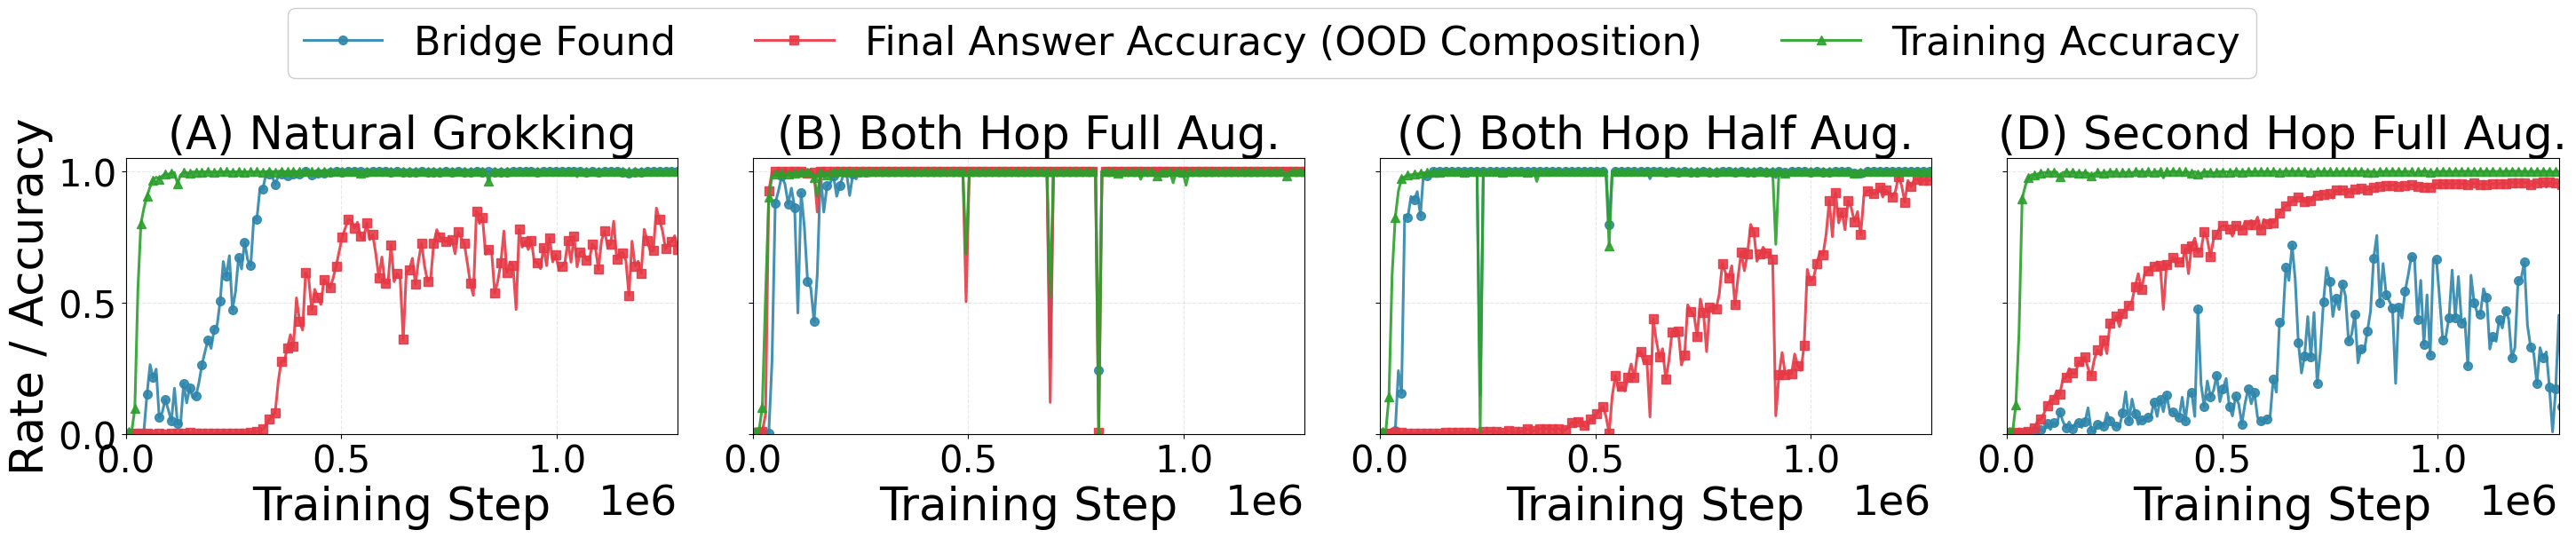

[{'checkpoint_dir': '../pretrain_finetune_results/Natural grokking pretraining',
  'steps': array([   7070,   14140,   21210,   28280,   35350,   42420,   49490,
           56560,   63630,   70700,   77770,   84840,   91910,   98980,
          106050,  113120,  120190,  127260,  134330,  141400,  148470,
          155540,  162610,  169680,  176750,  183820,  190890,  197960,
          205030,  212100,  219170,  226240,  233310,  240380,  247450,
          254520,  261590,  268660,  275730,  282800,  289870,  296940,
          304010,  311080,  318150,  325220,  332290,  339360,  346430,
          353500,  360570,  367640,  374710,  381780,  388850,  395920,
          402990,  410060,  417130,  424200,  431270,  438340,  445410,
          452480,  459550,  466620,  473690,  480760,  487830,  494900,
          501970,  509040,  516110,  523180,  530250,  537320,  544390,
          551460,  558530,  565600,  572670,  579740,  586810,  593880,
          600950,  608020,  615090,  622160,  

In [2]:
# your path to output folder here
checkpoint_dirs = [
    "../pretrain_finetune_results/Natural grokking pretraining", # to natural grokking.. 
    "../pretrain_finetune_results/Both hop full augmentation pretraining",
    "../pretrain_finetune_results/First hop full augmentation pretraining",
    "../pretrain_finetune_results/Second hop full augmentation pretraining"
]
labels = ["(A) Natural Grokking", "(B) Both Hop Full Aug.", "(C) Both Hop Half Aug.", "(D) Second Hop Full Aug."]
compare_circuit_formation_plot(
    checkpoint_dirs,
    labels=labels,
    x_max=1280000,
    font_scale=2.3,
    point_stride=1,  
    save_plot="Fig4_4folders",
)

In [3]:
import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional

_TOKEN_RE = re.compile(r"<[^>]+>")

def parse_tokens(text: str) -> List[str]:
    return _TOKEN_RE.findall(text or "")

def get_target_token(tokens: List[str]) -> Optional[str]:
    if "</a>" in tokens:
        idx = tokens.index("</a>")
        if idx > 0:
            return tokens[idx - 1]
    return None

def _eval_res(gold: str, pred: str) -> int:
    if gold is None or pred is None:
        return 0
    a = str(gold).strip()
    b = str(pred).strip()
    if "</a>" in a:
        a = a.split("</a>")[0]
    if "</a>" in b:
        b = b.split("</a>")[0]
    if "<a>" in a and "<a>" in b:
        try:
            return int(a.split("<a>")[1] == b.split("<a>")[1])
        except Exception:
            return int(a == b)
    return int(a == b)

def _safe_load_json_list(path: str) -> List[dict]:
    try:
        with open(path, "r", encoding="utf-8") as f:
            x = json.load(f)
        return x if isinstance(x, list) else []
    except Exception:
        return []

def _build_hr_to_bridge_from_all_atomic(all_items: List[dict]) -> Dict[Tuple[str, str], str]:
    """
    (h,r)->bridge from ANY atomic item (len(input_tokens)==2),
    regardless of type, so hop1 bridge can be recovered for both old/new.
    """
    hr_to_bridge: Dict[Tuple[str, str], str] = {}
    for it in all_items:
        if not isinstance(it, dict):
            continue
        inp = parse_tokens(it.get("input_text", "") or "")
        if len(inp) != 2:
            continue
        h, r = inp
        tgt = parse_tokens(it.get("target_text", "") or "")
        bridge = get_target_token(tgt)
        if bridge:
            hr_to_bridge[(h, r)] = bridge
    return hr_to_bridge

def _build_hr_set(all_items: List[dict], type_name: str) -> set:
    s = set()
    for it in all_items:
        if not isinstance(it, dict) or it.get("type") != type_name:
            continue
        inp = parse_tokens(it.get("input_text", "") or "")
        if len(inp) == 2:
            s.add((inp[0], inp[1]))
    return s

def _classify_inferred_3hop(
    input_text: str,
    *,
    hr_to_bridge: Dict[Tuple[str, str], str],
    atomic_new_hr_set: set,
    id_atomic_hr_set: set,
) -> Optional[str]:
    """
    Return one of:
      - 'new+old(id)'
      - 'old(id)+new'
      - 'new+new'
    or None if not in scope / cannot recover bridge / old not id_atomic.
    """
    toks = parse_tokens(input_text or "")
    if len(toks) != 3:
        return None
    h, r1, r2 = toks

    bridge = hr_to_bridge.get((h, r1), None)
    if bridge is None:
        return None

    hop1_new = (h, r1) in atomic_new_hr_set
    hop2_new = (bridge, r2) in atomic_new_hr_set

    hop1_id = (h, r1) in id_atomic_hr_set
    hop2_id = (bridge, r2) in id_atomic_hr_set

    # new + old(id-only): hop1 new; hop2 must be id_atomic and NOT new
    if hop1_new and (not hop2_new) and hop2_id:
        return "new+old(id)"

    # old(id-only) + new: hop1 must be id_atomic and NOT new; hop2 new
    if (not hop1_new) and hop1_id and hop2_new:
        return "old(id)+new"

    # new + new
    if hop1_new and hop2_new:
        return "new+new"

    return None

def _bridge_found_any_stage(sample: dict, true_bridge: str) -> Optional[int]:
    """
    Return 1/0 if analyzable, else None (missing trace, etc.).
    Compatible with common trace layouts.
    """
    trace = sample.get("logit_lens_trace", None)
    if trace is None:
        trace = sample.get("logit_lens", None)
    if not isinstance(trace, list) or len(trace) == 0:
        return None

    for stage in trace:
        preds = None
        if isinstance(stage, dict):
            preds = stage.get("predictions", None)
            if preds is None:
                preds = stage.get("topk", None)
        if isinstance(preds, dict):
            preds = list(preds.keys())
        preds = preds or []
        if true_bridge in preds:
            return 1
    return 0


def collect_3mix_series(checkpoint_dir: str, *, num_checkpoints: Optional[int] = None):
    """
    For one folder, return:
      steps,
      per_cat: bridge_found_rate, em_acc, counts
      + atomic_new_acc (EM on type=='atomic_new')

    Args:
      num_checkpoints: if set, only load the first N checkpoints (by ascending step).
    """
    pattern = os.path.join(checkpoint_dir, "checkpoint-*")
    ckpts = [p for p in glob.glob(pattern) if os.path.isdir(p)]
    if not ckpts:
        raise FileNotFoundError(f"No checkpoints found under {checkpoint_dir}")

    ckpt_rows = []
    for p in ckpts:
        m = re.search(r"checkpoint-(\d+)", p)
        if not m:
            continue
        step = int(m.group(1))
        all_items_path = os.path.join(p, "all_items.json")
        logit_path = os.path.join(p, "logit_lens_ood.json")
        if os.path.exists(all_items_path):
            ckpt_rows.append((step, all_items_path, logit_path))

    ckpt_rows.sort(key=lambda x: x[0])
    if not ckpt_rows:
        raise RuntimeError(f"No valid checkpoints with all_items.json under {checkpoint_dir}")

    # early slicing for speed
    if num_checkpoints is not None:
        if not isinstance(num_checkpoints, int):
            raise TypeError(f"num_checkpoints must be int or None, got {type(num_checkpoints)}")
        if num_checkpoints <= 0:
            raise ValueError(f"num_checkpoints must be >= 1 when set, got {num_checkpoints}")
        ckpt_rows = ckpt_rows[: min(num_checkpoints, len(ckpt_rows))]

    cats = ["new+old(id)", "old(id)+new", "new+new"]
    out = {
        "checkpoint_dir": checkpoint_dir,
        "steps": [],
        "bridge": {c: [] for c in cats},
        "em": {c: [] for c in cats},
        "n_em": {c: [] for c in cats},
        "n_bridge": {c: [] for c in cats},
        # NEW: atomic_new curve (same for all 3 panels in this folder)
        "atomic_new_acc": [],
        "n_atomic_new": [],
    }

    for step, all_items_path, logit_path in tqdm(
        ckpt_rows,
        desc=f"Collecting 3mix — {os.path.basename(checkpoint_dir)}",
    ):
        all_items = _safe_load_json_list(all_items_path)
        logit_data = _safe_load_json_list(logit_path) if os.path.exists(logit_path) else []

        hr_to_bridge = _build_hr_to_bridge_from_all_atomic(all_items)
        atomic_new_hr_set = _build_hr_set(all_items, "atomic_new")
        id_atomic_hr_set = _build_hr_set(all_items, "id_atomic")

        # --- atomic_new EM acc (final output) ---
        atomic_new_hits = []
        for it in all_items:
            if not isinstance(it, dict) or it.get("type") != "atomic_new":
                continue
            pred = it.get("model_output", it.get("model output", None))
            gold = it.get("target_text", it.get("target text", None))
            atomic_new_hits.append(_eval_res(gold, pred))
        out["n_atomic_new"].append(len(atomic_new_hits))
        out["atomic_new_acc"].append(float(np.mean(atomic_new_hits)) if atomic_new_hits else np.nan)

        # --- Exact match for the 3 mix categories ---
        em_correct: Dict[str, List[int]] = {c: [] for c in cats}
        for it in all_items:
            if not isinstance(it, dict):
                continue
            inp = it.get("input_text", "") or ""
            cat = _classify_inferred_3hop(
                inp,
                hr_to_bridge=hr_to_bridge,
                atomic_new_hr_set=atomic_new_hr_set,
                id_atomic_hr_set=id_atomic_hr_set,
            )
            if cat is None:
                continue
            pred = it.get("model_output", it.get("model output", None))
            gold = it.get("target_text", it.get("target text", None))
            em_correct[cat].append(_eval_res(gold, pred))

        # --- Bridge found from logit_lens ---
        bridge_hits: Dict[str, List[int]] = {c: [] for c in cats}
        for s in logit_data:
            if not isinstance(s, dict):
                continue
            inp = s.get("input_text", "") or ""
            toks = parse_tokens(inp)
            if len(toks) != 3:
                continue
            h, r1, _r2 = toks

            true_bridge = hr_to_bridge.get((h, r1), None)
            if true_bridge is None:
                continue

            cat = _classify_inferred_3hop(
                inp,
                hr_to_bridge=hr_to_bridge,
                atomic_new_hr_set=atomic_new_hr_set,
                id_atomic_hr_set=id_atomic_hr_set,
            )
            if cat is None:
                continue

            hit = _bridge_found_any_stage(s, true_bridge=true_bridge)
            if hit is None:
                continue
            bridge_hits[cat].append(hit)

        out["steps"].append(step)
        for c in cats:
            n_em = len(em_correct[c])
            out["n_em"][c].append(n_em)
            out["em"][c].append(float(np.mean(em_correct[c])) if n_em else np.nan)

            n_br = len(bridge_hits[c])
            out["n_bridge"][c].append(n_br)
            out["bridge"][c].append(float(np.mean(bridge_hits[c])) if n_br else np.nan)

    out["steps"] = np.array(out["steps"], dtype=int)
    out["atomic_new_acc"] = np.array(out["atomic_new_acc"], dtype=float)
    out["n_atomic_new"] = np.array(out["n_atomic_new"], dtype=int)

    for c in cats:
        out["bridge"][c] = np.array(out["bridge"][c], dtype=float)
        out["em"][c] = np.array(out["em"][c], dtype=float)
        out["n_em"][c] = np.array(out["n_em"][c], dtype=int)
        out["n_bridge"][c] = np.array(out["n_bridge"][c], dtype=int)
    return out


def compare_circuit_formation_plot_3mix(
    checkpoint_dirs: List[str],
    labels: Optional[List[str]] = None,
    *,
    x_max: Optional[int] = None,
    point_stride: int = 0,
    font_scale: float = 2.3,
    save_plot: Optional[str] = None,
    set_limit: bool = True,
    num_checkpoints: Optional[int] = None,
    figsize: Tuple[float, float] = (30, 26),
):
    """
    Make an N x 3 plot:
      rows: N data folders (= len(checkpoint_dirs))
      cols: new+old(id), old(id)+new, new+new

    Each subplot draws 3 curves:
      - Bridge Found (Any Stage)
      - Exact-Match Acc (final output) for this category
      - atomic_new Acc (final output; type=='atomic_new') [same curve repeated across columns]
    """
    if not isinstance(checkpoint_dirs, list) or len(checkpoint_dirs) == 0:
        raise ValueError("checkpoint_dirs must be a non-empty list of checkpoint directory paths")

    n_rows = len(checkpoint_dirs)

    if labels is None:
        labels = [os.path.basename(d.rstrip("/")) or f"folder_{i}" for i, d in enumerate(checkpoint_dirs)]
    if not isinstance(labels, list) or len(labels) != n_rows:
        raise ValueError(f"labels must be a list of length {n_rows} (or None), got {len(labels) if isinstance(labels, list) else type(labels)}")

    if not isinstance(point_stride, int) or point_stride < 0:
        raise ValueError(f"point_stride must be int >= 0, got {point_stride}")
    if not isinstance(font_scale, (int, float)) or font_scale <= 0:
        raise ValueError(f"font_scale must be > 0, got {font_scale}")

    base = {"rc_font": 15, "title": 16, "xlabel": 16, "ylabel": 16, "tick": 13, "legend": 14}
    sz = {k: int(round(v * float(font_scale))) for k, v in base.items()}
    plt.rcParams.update({"font.size": sz["rc_font"]})

    cats = ["new+old(id)", "old(id)+new", "new+new"]
    cat_titles = {
        "new+old(id)": "new facts + old facts",
        "old(id)+new": "old facts + new facts",
        "new+new": "new facts + new facts",
    }

    series = [collect_3mix_series(d, num_checkpoints=num_checkpoints) for d in checkpoint_dirs]

    fig, axs = plt.subplots(n_rows, 3, figsize=figsize, sharey=set_limit)

    # normalize axs to shape (n_rows, 3)
    axs = np.array(axs)
    if axs.ndim == 1:
        # happens when n_rows == 1
        axs = axs.reshape(1, 3)
    elif axs.shape != (n_rows, 3):
        axs = axs.reshape(n_rows, 3)

    markevery = None if point_stride == 0 else (point_stride + 1)

    handles, legend_labels = [], []
    for i in range(n_rows):
        s = series[i]
        x = s["steps"]

        for j, c in enumerate(cats):
            ax = axs[i, j]

            l1, = ax.plot(
                x, s["bridge"][c],
                marker="o",
                markersize=7,
                linewidth=2.2,
                color="#2E86AB",
                alpha=0.92,
                label="Bridge Found",
                markevery=markevery,
            )
            l2, = ax.plot(
                x, s["em"][c],
                marker="^",
                markersize=7,
                linewidth=2.2,
                color="#2ca02c",
                alpha=0.92,
                label="Final Answer Accuracy (Composition new facts)",
                markevery=markevery,
            )
            l3, = ax.plot(
                x, s["atomic_new_acc"],
                marker="s",
                markersize=7,
                linewidth=2.2,
                color="#ff7f0e",
                alpha=0.92,
                label="New Fact Acc",
                markevery=markevery,
            )

            # collect legend once
            if i == 0 and j == 0:
                handles.extend([l1, l2, l3])
                legend_labels.extend([
                    "Bridge Found",
                    "Final Answer Accuracy (Composition new facts)",
                    "New Fact Acc",
                ])

            if i == 0:
                ax.set_title(cat_titles[c], fontsize=sz["title"])
            if j == 0:
                ax.set_ylabel(f"{labels[i]}\nRate / Accuracy", fontsize=sz["ylabel"])
            ax.set_xlabel("Training Step", fontsize=sz["xlabel"])

            ax.set_ylim([0, 1.05])
            if x_max is not None:
                ax.set_xlim([0, x_max])
            else:
                ax.set_xlim([0, (max(x) * 1.02) if len(x) else 1])

            ax.grid(True, linestyle="--", alpha=0.3,linewidth=2.0)
            ax.tick_params(axis="y", labelsize=sz["tick"])
            ax.tick_params(axis="x", labelsize=sz["tick"])

    fig.legend(
        handles, legend_labels,
        bbox_to_anchor=(0.5, 1.02),
        loc="upper center",
        ncol=3,
        fontsize=sz["legend"],
        framealpha=0.95,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    if save_plot:
        root_folder = "Figures"
        os.makedirs(root_folder, exist_ok=True)
        out_pdf = os.path.join(root_folder, save_plot) + ".pdf"
        out_png = os.path.join(root_folder, save_plot) + ".png"
        plt.savefig(out_pdf, format="pdf", bbox_inches="tight", dpi=300)
        plt.savefig(out_png, format="png", bbox_inches="tight", dpi=300)
        print(f"[saved] {out_pdf}")
        print(f"[saved] {out_png}")

    plt.show()
    return series


[saved] Figures/Fig4_3mix_4x3_first30.pdf
[saved] Figures/Fig4_3mix_4x3_first30.png


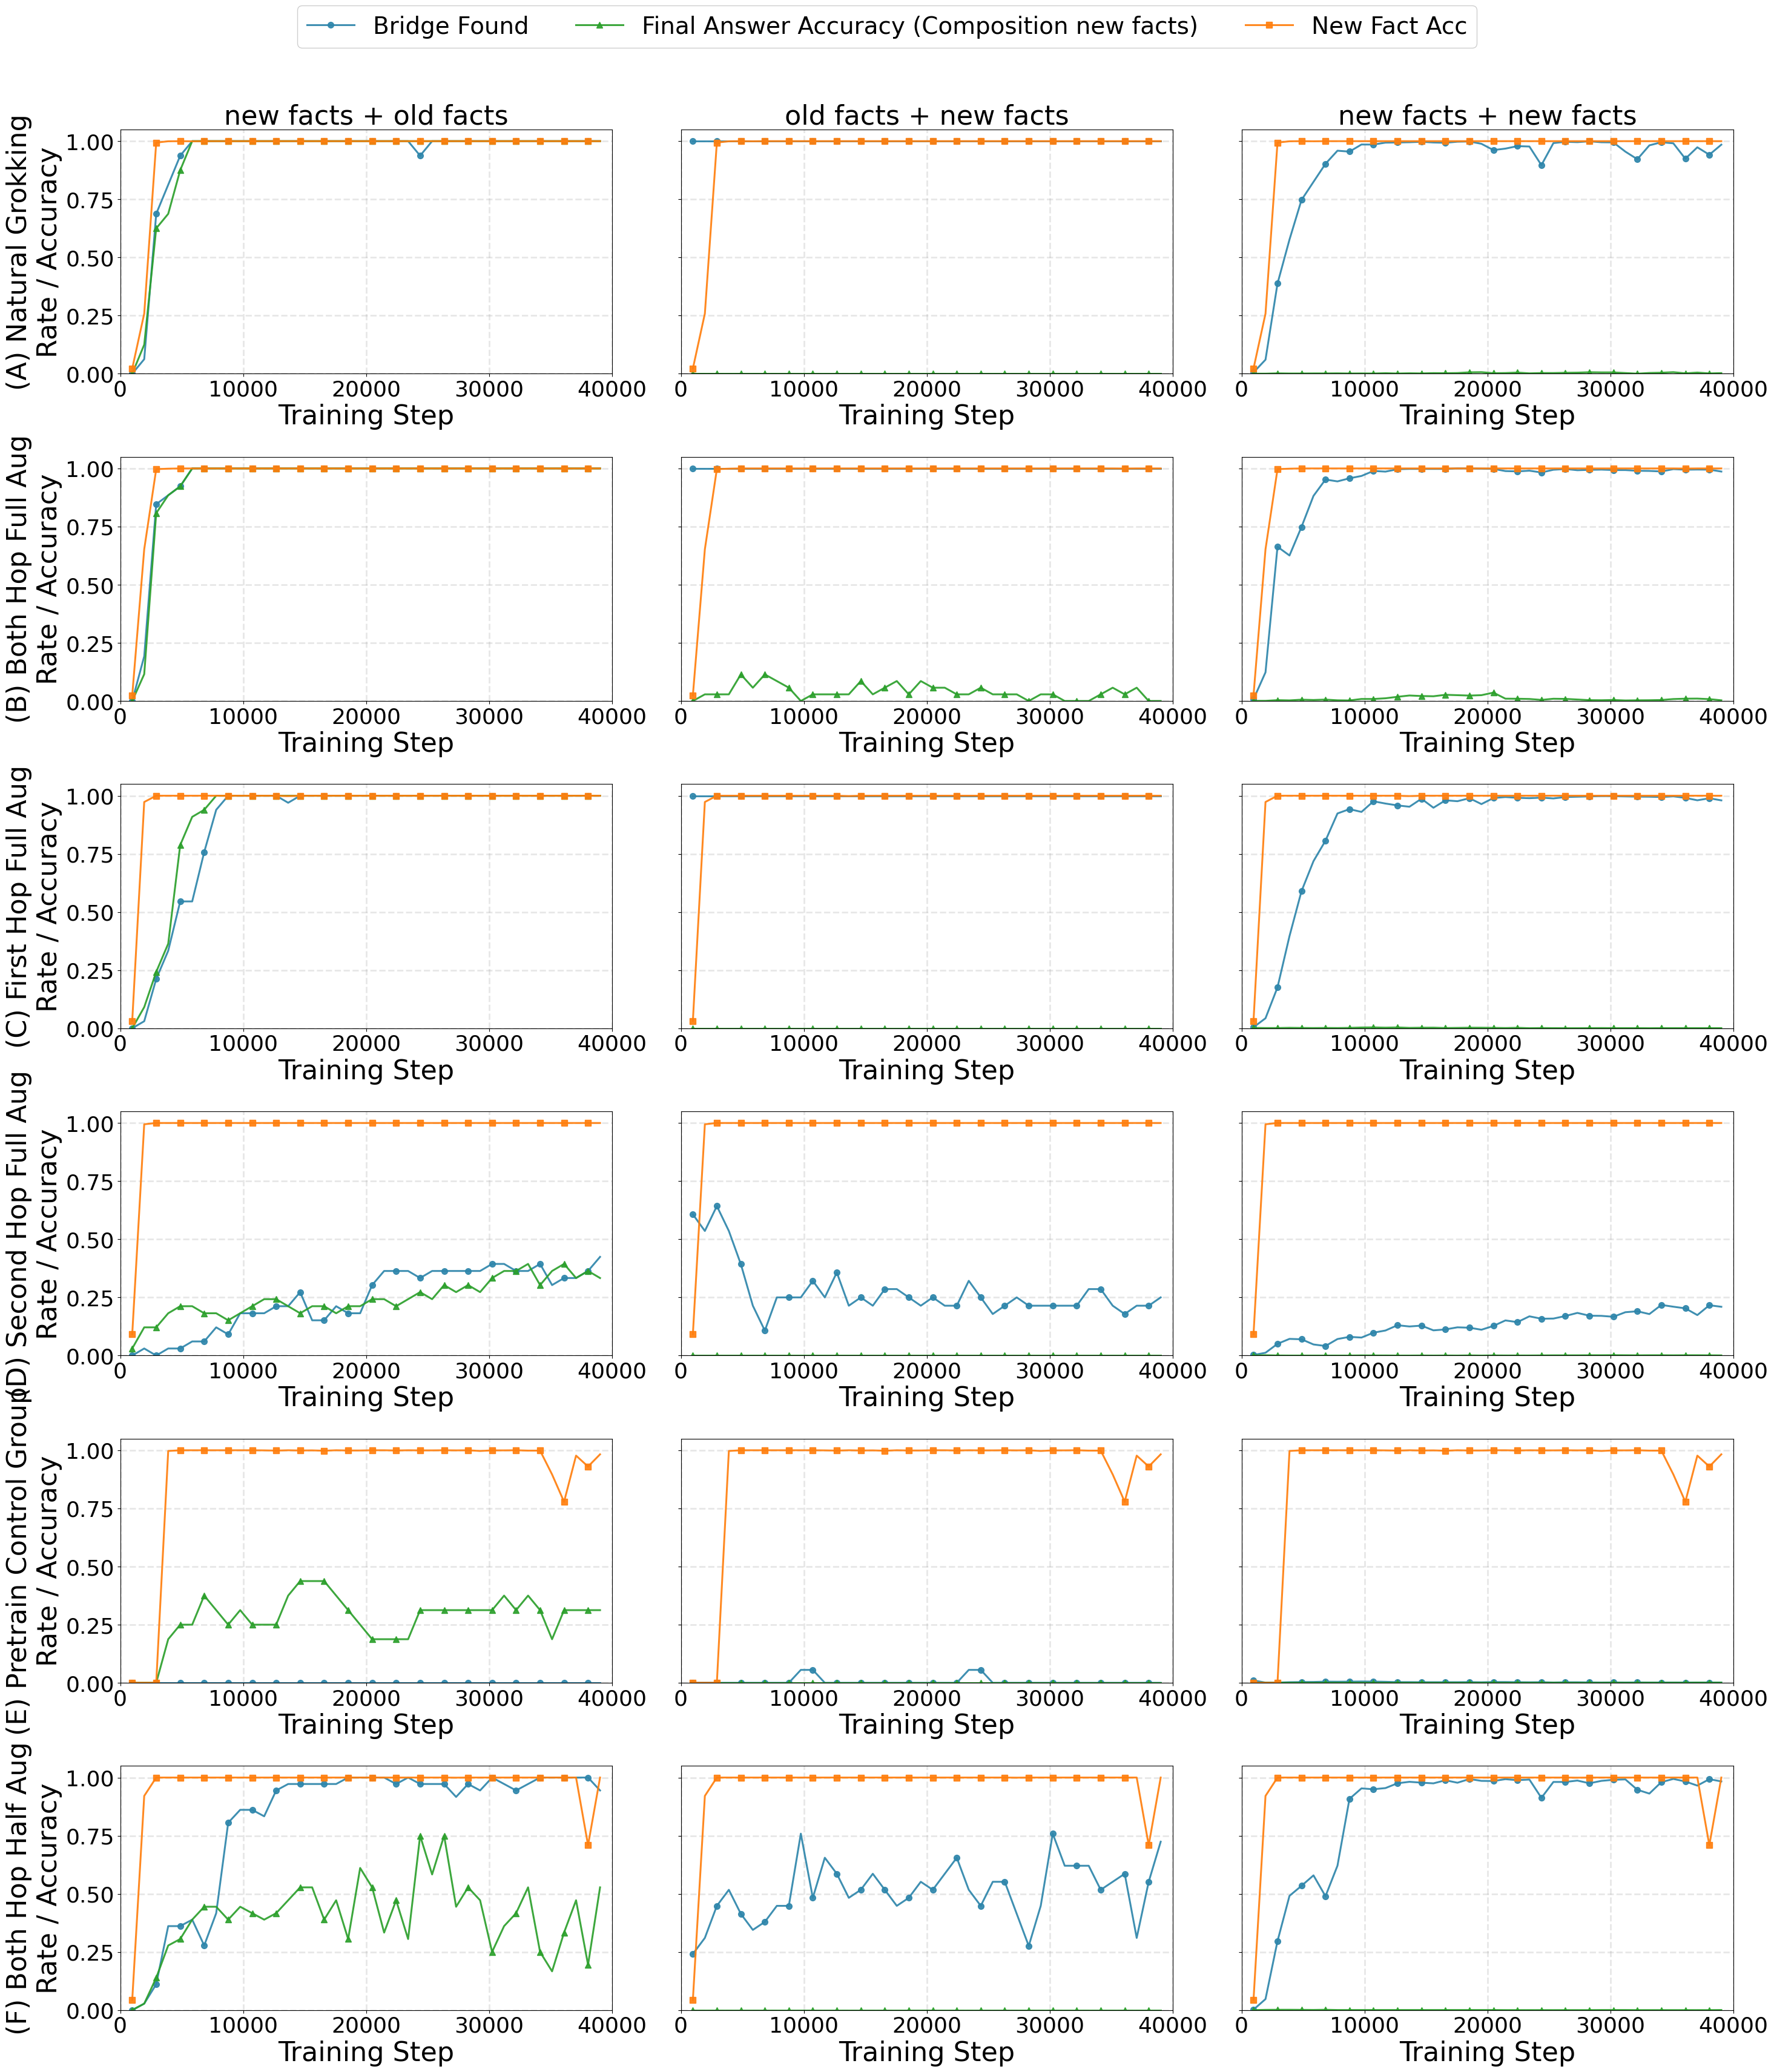

[{'checkpoint_dir': '../pretrain_finetune_results/Natural grokking finetuning',
  'steps': array([  976,  1952,  2928,  3904,  4880,  5856,  6832,  7808,  8784,
          9760, 10736, 11712, 12688, 13664, 14640, 15616, 16592, 17568,
         18544, 19520, 20496, 21472, 22448, 23424, 24400, 25376, 26352,
         27328, 28304, 29280, 30256, 31232, 32208, 33184, 34160, 35136,
         36112, 37088, 38064, 39040]),
  'bridge': {'new+old(id)': array([0.    , 0.0625, 0.6875, 0.8125, 0.9375, 1.    , 1.    , 1.    ,
          1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
          1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
          0.9375, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
          1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ]),
   'old(id)+new': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.

In [5]:
# your path here to all dirs 
checkpoint_dirs = [
    "../pretrain_finetune_results/Natural grokking finetuning",
    "../pretrain_finetune_results/Both hop full augmentation finetuning",
    "../pretrain_finetune_results/First hop full augmentation finetuning",
    "../pretrain_finetune_results/Second hop full augmentation finetuning",
    "../pretrain_finetune_results/Control Group finetuning",
    "../pretrain_finetune_results/Both hop half augmentation finetuning",
]
labels = ["(A) Natural Grokking", "(B) Both Hop Full Aug", "(C) First Hop Full Aug", "(D) Second Hop Full Aug", "(E) Pretrain Control Group", "(F) Both Hop Half Aug"]

compare_circuit_formation_plot_3mix(
    checkpoint_dirs,
    labels=labels,
    x_max=40000,
    font_scale=2.0,
    point_stride=1,
    num_checkpoints=40,
    figsize=(30, 34),   
    save_plot="Fig4_3mix_4x3_first30",
)